In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=6, micro=6, releaselevel='final', serial=0)

In [2]:
test=pd.read_csv('test.csv')
train=pd.read_csv('sales_train.csv')
item_categories=pd.read_csv('item_categories.csv')
items=pd.read_csv('items.csv')
shops=pd.read_csv('shops.csv')
sample=pd.read_csv('sample_submission.csv')

In [3]:
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

**Visualizing for detecting outliers**

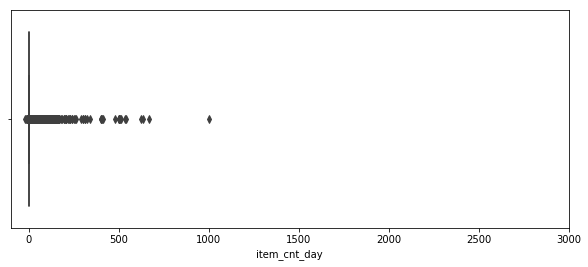

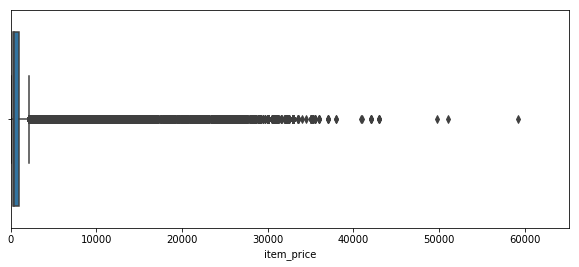

In [35]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [4]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [5]:
test['date_block_num']=34

**Preprocesing**

In [6]:
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [7]:
item_categories['split'] = item_categories['item_category_name'].str.split('-')
item_categories['type'] = item_categories['split'].map(lambda x: x[0].strip())
item_categories['type_code'] = LabelEncoder().fit_transform(item_categories['type'])

In [8]:
item_categories['subtype'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['subtype_code'] = LabelEncoder().fit_transform(item_categories['subtype'])
item_categories = item_categories[['item_category_id','type_code', 'subtype_code']]


In [9]:
matrix = []
cols = ['date_block_num','shop_id','item_id']

for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

In [10]:
matrix.shape[0]-train.shape[0]

7977957

**Monthly Sales**

In [11]:
e = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
e.columns = ['item_cnt_month']
e.reset_index(inplace=True)

matrix = pd.merge(matrix,e, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16)) # NB clip target here

**Concatenating train and test **

In [12]:
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 mont

In [13]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, item_categories, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

** LAG FEATURES **

In [14]:
def lag_feature(df, lags, col):
    fl = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = fl.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [15]:
matrix = lag_feature(matrix, [1,2,3,6,10,12], 'item_cnt_month')

In [16]:

group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,6], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)


In [17]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,10], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)


In [18]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)


In [19]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

In [20]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

In [21]:
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)


In [22]:
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)


In [23]:
group = matrix.groupby(['date_block_num', 'type_code','subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code','subtype_code'], how='left')
matrix['date_type_subtype_avg_item_cnt'] = matrix['date_type_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_subtype_avg_item_cnt')
matrix.drop(['date_type_subtype_avg_item_cnt'], axis=1, inplace=True)


** Generating new features **

In [24]:
matrix['month'] = matrix['date_block_num'] % 12

In [25]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [26]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)


In [30]:
matrix=matrix.drop(['item_name'],axis=1)

Data splitting

In [31]:
X_train = matrix[matrix.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = matrix[matrix.date_block_num < 33]['item_cnt_month']
X_valid = matrix[matrix.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = matrix[matrix.date_block_num == 33]['item_cnt_month']
X_test = matrix[matrix.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [32]:
model = XGBRegressor(max_depth=8,n_estimators=1000,min_child_weight=300, colsample_bytree=0.8, subsample=0.8, eta=0.25,seed=42)


model.fit(X_train, Y_train, eval_metric="rmse", eval_set=[(X_train, Y_train), (X_valid, Y_valid)], verbose=True, early_stopping_rounds = 10)

[19:30:12] WARNING: /workspace/src/gbm/gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.14724	validation_1-rmse:1.08358
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.05400	validation_1-rmse:1.02489
[2]	validation_0-rmse:1.00508	validation_1-rmse:0.99474
[3]	validation_0-rmse:0.97416	validation_1-rmse:0.97540
[4]	validation_0-rmse:0.95578	validation_1-rmse:0.96553
[5]	validation_0-rmse:0.94386	validation_1-rmse:0.96007
[6]	validation_0-rmse:0.93609	validation_1-rmse:0.95531
[7]	validation_0-rmse:0.93106	validation_1-rmse:0.95321
[8]	validation_0-rmse:0.92727	validation_1-rmse:0.95370
[9]	validation_0-rmse:0.92447	validation_1-rmse:0.95367
[10]	validation_0-rmse:0.92032	validation_1-rmse:0.94905
[11]	va

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.25, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.25, max_delta_step=0, max_depth=8,
             min_child_weight=300, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=42, subsample=0.8,
             tree_method=None, validate_parameters=False, verbosity=None)

In [33]:
pred=model.predict(X_test)